In [6]:
import sys
# sys.path.append("/data/home/jinyalong/git/txdas/biotech/notebook/SEV_Promoter")
# print(sys.path)
from gem.models import CNN
from gem.utils import *
from gem.datasets import NPDataset
from gem.transformer import ConvBERT
from torchinfo import summary
import Levenshtein
import pandas as pd
import scipy.stats as stats
from sklearn import preprocessing
import torch
from torch import utils
from torch import nn
from torch import optim
from sklearn.model_selection import StratifiedShuffleSplit,ShuffleSplit
import tqdm
device = "cuda:0"
tlp = "/data/home/jinyalong/git/txdas/biotech/notebook/SEV_Promoter"

def train(model, train_loader,test_loader,patience=3,epochs=20):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-06)
    # optimizer = optim.Adam(model.parameters(), lr=0.0033, betas=(0.9, 0.999), eps=3.43e-4)
    # scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=30)
    early_stopping = EarlyStopping(patience=patience)
    lst, vlst = [],[]
    for epoch in range(epochs):
        model.train()
        train_epoch_loss=[]
        for idx, (x, y) in tqdm.tqdm(enumerate(train_loader)):
            outputs = model(x.to(device))
            optimizer.zero_grad()
            loss = criterion(y.to(device), outputs)
            loss.backward()
            train_epoch_loss.append(loss.detach().item())
            optimizer.step()
            # scheduler.step()
        train_loss = np.average(train_epoch_loss)
        valid_epoch_loss = []
        model.eval()
        for idx, (data_x, data_y) in enumerate(test_loader):
            outputs = model(data_x.to(device))
            loss = criterion(data_y.to(device), outputs)
            valid_epoch_loss.append(loss.detach().item())
        valid_loss = np.average(valid_epoch_loss)
        print("epoch={}/{} of train, train loss={}, valid loss={}".format(epoch + 1, epochs,train_loss, valid_loss))
        lst.append(train_loss)
        vlst.append(valid_loss)

        if early_stopping.early_stop(model,valid_loss):
            break
    return early_stopping.best_model,pd.DataFrame(data={"loss":lst,"val_loss":vlst})

def test_data(df, model, test_seq, obs_col, output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''
    # Scale the test set mean ribosome load
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].values.reshape(-1,1))
    # Make predictions
    model.eval()
    predictions = model(torch.tensor(test_seq,dtype=torch.float).to(device)).reshape(-1,1).cpu().detach().numpy()
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df


def my_init(m):
    if isinstance(m, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)
        # nn.init.normal_(m.weight, mean=0.0, std=0.05)
        # nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=0.05)
        nn.init.constant_(m.bias, 0)


def reverse_rna(seq='atgggcggcgcatgagagaagcccagaccaattacctacccaaa'):
    d = {"A":"U","C":"G","G":"C","T":"A"}
    return "".join([d[c.upper()] for c in seq])


original_seq = 'atgggcggcgcatgagagaagcccagaccaattacctacccaaa'
original_seq=original_seq.upper()
name,seq_len,suff = "pl3-1-2",118,"" # _seq exp12-merge pl3-1-2 2-D11-merge core6-merge
datadir=f"/data/home/jinyalong/data/sev_240624/results/{name}/{name}_"
e_train = pd.read_csv(f"{datadir}train{suff}.csv")
e_test= pd.read_csv(f"{datadir}test{suff}.csv")
e_train["seq"] = e_train.seq.apply(reverse_rna)
e_test["seq"] = e_test.seq.apply(reverse_rna)
# datadir=f"/data/home/jinyalong/data/sev_241110/results/{name}/{name}_"
# datadir=f"/data/home/jinyalong/data/sev_241023/results/{name}/{name}_"
# df = pd.read_csv(f"{datadir}final{suff}.csv")
# split = ShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
# for train_idx, test_idx in split.split(df):
#     e_train = df.iloc[train_idx].reset_index(drop=True)
#     e_test = df.iloc[test_idx].reset_index(drop=True)
# e_train['distance'] = e_train.seq.apply(lambda x: Levenshtein.distance(original_seq, x))
# e_test['distance'] = e_test.seq.apply(lambda x: Levenshtein.distance(original_seq, x))
# e_train["score"] = e_train['score_final']
# e_test["score"] = e_test['score_final']
print(e_train.shape, e_test.shape )
label="score"
batch_size= 64 # 64, 256
kernel_size = 5
seed =41 # 43

train_x = one_hot_encode(e_train,seq_len=seq_len)
test_x = one_hot_encode(e_test, seq_len=seq_len)
test_y = preprocessing.StandardScaler().fit_transform(e_test.loc[:,label].values.reshape(-1,1))
tran_y = preprocessing.StandardScaler().fit_transform(e_train.loc[:,label].values.reshape(-1,1))
dataset_train = NPDataset(train_x,tran_y)
dataset_test = NPDataset(test_x,test_y)
valid_len = int(len(dataset_train)*0.1)
train_dataset, valid_dataset = torch.utils.data.random_split(
    dataset_train, [len(dataset_train)-valid_len,valid_len],
    generator=torch.Generator().manual_seed(seed))
train_loader = utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
valid_loader = utils.data.DataLoader(valid_dataset, batch_size=batch_size,shuffle=False)
test_loader = utils.data.DataLoader(dataset_test, batch_size=batch_size)
set_seed(seed)
model = CNN(seq_len=seq_len,kernel_size=kernel_size)
# model = ConvBERT(in_channels=4, dim_model=128,kernel_size=kernel_size, num_heads=8,
#                  dropout_p=0.2,max_len=seq_len)
model.apply(my_init)
model = model.to(device)
model,pdf=train(model, train_loader, valid_loader,patience=10,epochs=40) # 10,50
# model = torch.load(f"./models/{name}.pt")
test_data(df=e_test, model=model, obs_col=label,test_seq=test_x)
r = r2(e_test['pred'],e_test["score"])
pr =  stats.pearsonr(e_test['pred'],e_test["score"] )
print(f'test {name} r-squared = ', r, "pearsonR = ", pr[0])
# torch.save(model,f"{tlp}/models/{name}-{kernel_size}.pt")
torch.save(model.state_dict(),f"{tlp}/models/{name}-{kernel_size}.pt")

(2959, 8) (156, 8)


42it [00:00, 234.51it/s]


epoch=1/40 of train, train loss=1.355025203455062, valid loss=0.9694089293479919


42it [00:00, 241.24it/s]


epoch=2/40 of train, train loss=1.0030425602481479, valid loss=0.9674430131912232


42it [00:00, 223.42it/s]


epoch=3/40 of train, train loss=0.9940841056051708, valid loss=0.9324015378952026


42it [00:00, 224.63it/s]


epoch=4/40 of train, train loss=0.8965081529957908, valid loss=0.6608873844146729


42it [00:00, 219.73it/s]


epoch=5/40 of train, train loss=0.7158925433953603, valid loss=0.6293120145797729


42it [00:00, 218.98it/s]


epoch=6/40 of train, train loss=0.6494699787525904, valid loss=0.572955048084259


42it [00:00, 219.12it/s]


epoch=7/40 of train, train loss=0.5988055524371919, valid loss=0.5455336332321167


42it [00:00, 219.40it/s]


epoch=8/40 of train, train loss=0.597622465519678, valid loss=0.5484680294990539


42it [00:00, 217.73it/s]


epoch=9/40 of train, train loss=0.5734480278832572, valid loss=0.5375960528850555


42it [00:00, 212.02it/s]


epoch=10/40 of train, train loss=0.5598391031935102, valid loss=0.6328183650970459


42it [00:00, 213.39it/s]


epoch=11/40 of train, train loss=0.5596062718402772, valid loss=0.5319915235042572


42it [00:00, 222.62it/s]


epoch=12/40 of train, train loss=0.5418400019407272, valid loss=0.5339874207973481


42it [00:00, 229.31it/s]


epoch=13/40 of train, train loss=0.5518552639654705, valid loss=0.5257487237453461


42it [00:00, 221.00it/s]

epoch=14/40 of train, train loss=0.534825603167216, valid loss=0.5952862977981568



42it [00:00, 244.47it/s]


epoch=15/40 of train, train loss=0.544556071360906, valid loss=0.5116626799106598


42it [00:00, 233.73it/s]


epoch=16/40 of train, train loss=0.5268066497076125, valid loss=0.5461365818977356


42it [00:00, 230.29it/s]


epoch=17/40 of train, train loss=0.5124529628526597, valid loss=0.5260434567928314


42it [00:00, 237.81it/s]


epoch=18/40 of train, train loss=0.5339079598585764, valid loss=0.5256615996360778


42it [00:00, 227.07it/s]


epoch=19/40 of train, train loss=0.5080208686136064, valid loss=0.5890987753868103


42it [00:00, 247.80it/s]


epoch=20/40 of train, train loss=0.5136890624250684, valid loss=0.5282156527042389


42it [00:00, 253.08it/s]


epoch=21/40 of train, train loss=0.5068690791016534, valid loss=0.5275667786598206


42it [00:00, 246.15it/s]


epoch=22/40 of train, train loss=0.5136459498178392, valid loss=0.5335778176784516


42it [00:00, 242.81it/s]


epoch=23/40 of train, train loss=0.5154281932683218, valid loss=0.5190124630928039


42it [00:00, 229.66it/s]


epoch=24/40 of train, train loss=0.5019538054863611, valid loss=0.5383921027183532


42it [00:00, 234.46it/s]


epoch=25/40 of train, train loss=0.5042899229696819, valid loss=0.5479418277740479
test pl3-1-2 r-squared =  0.6129167403345351 pearsonR =  0.7828899924858763


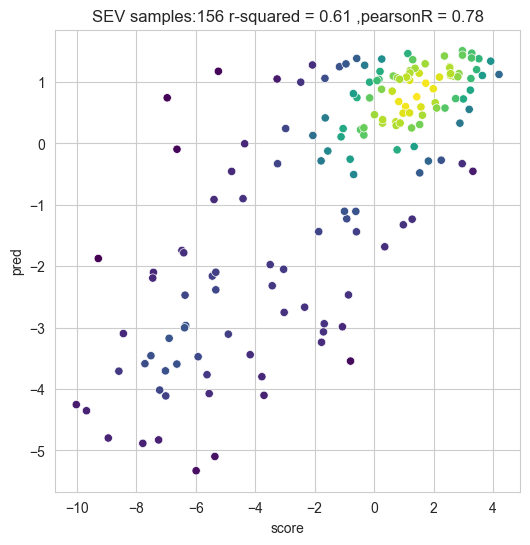

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sdf=e_test
num=len(sdf)
name = name.split("_")[0] if "_"in name else "SEV"
values = np.vstack([sdf["score"], sdf['pred']])
kernel = stats.gaussian_kde(values)(values)
fig, ax = plt.subplots(figsize=(6, 6))
r = r2(sdf["score"],sdf["pred"])
pr =  stats.pearsonr(sdf["score"],sdf["pred"])
plt.title(f"{name} samples:{num} r-squared = {r:.2f} ,pearsonR = {pr[0]:.2f}")
splot=sns.scatterplot(
    data=sdf,
    x="score",
    y="pred",
    c=kernel,
    cmap="viridis",
    ax=ax,
)

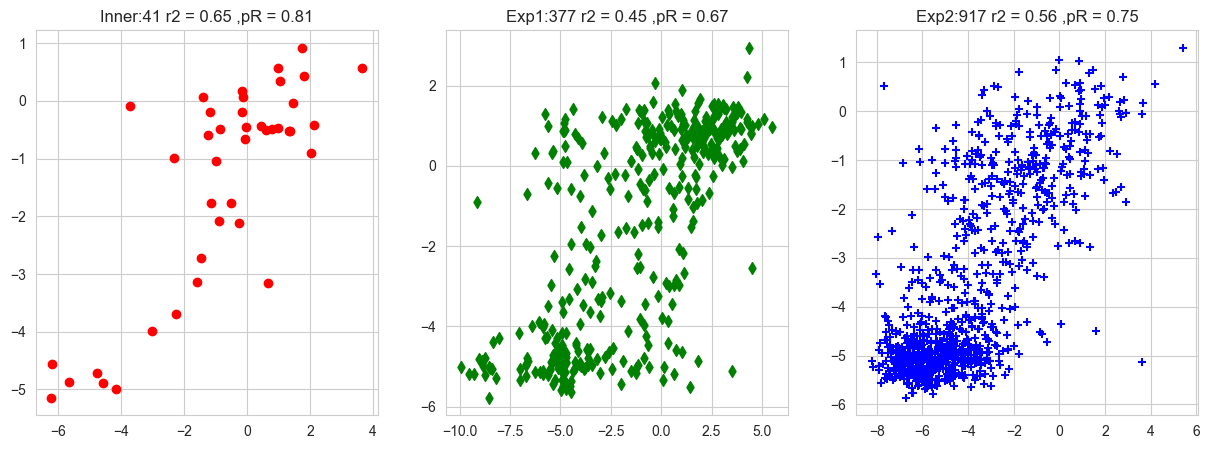

In [94]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
sdf=e_test
plt.figure(figsize=(15,5))
for i in range(3):
    sdf = e_test[e_test["flag"]==i]
    plt.subplot(1,3,i+1)
    pr =  stats.pearsonr(sdf["score"],sdf["pred"])
    r = r2(sdf["score"],sdf["pred"])
    name = "Inner" if i==0 else "Exp1" if i==1 else "Exp2"
    marker = "o" if i==0 else "d" if i==1 else "+"
    color = "r" if i==0 else "g" if i==1 else "b"
    plt.title(f"{name}:{len(sdf)} r2 = {r:.2f} ,pR = {pr[0]:.2f}")
    plt.scatter(sdf["score"], sdf["pred"], marker=marker, color=color)
plt.show()


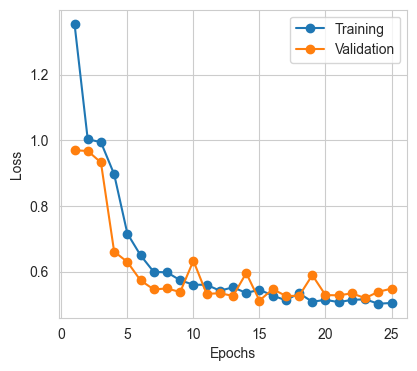

In [3]:
import matplotlib
from matplotlib import pyplot
import pickle
import pandas
import numpy
import scipy
import seaborn
# Plot training/validation losses
f, ax = pyplot.subplots(1, 1, figsize=(4.5, 4))
n_epochs_actual = len(pdf['loss'])

ax.plot(
    numpy.arange(1, n_epochs_actual + 1),
    pdf['loss'],
    marker='o',
    label='Training',
)
ax.plot(
    numpy.arange(1, n_epochs_actual + 1),
    pdf['val_loss'],
    marker='o',
    label='Validation',
)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.legend()